#Classical Image Segmentation Pipeline

In [15]:
#Import libraries
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, morphology, filters
from skimage.exposure import match_histograms
from skimage.morphology import reconstruction
from skimage.util import invert

In [16]:
#Connect with google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
#Read file in Drive
#Original Images
from skimage import io
im1 = io.imread('/content/drive/MyDrive/OCT_Dataset/img_dir/TRAINING1.tif',)
im2 = io.imread('/content/drive/MyDrive/OCT_Dataset/img_dir/TRAINING2.tif',)
im3 = io.imread('/content/drive/MyDrive/OCT_Dataset/img_dir/TRAINING3.tif',)
im4 = io.imread('/content/drive/MyDrive/OCT_Dataset/img_dir/TRAINING4.tif',)
im5 = io.imread('/content/drive/MyDrive/OCT_Dataset/img_dir/TRAINING5.tif')
im6 = io.imread('/content/drive/MyDrive/OCT_Dataset/img_dir/TRAINING6.tif')
im7 = io.imread('/content/drive/MyDrive/OCT_Dataset/img_dir/TRAINING7.tif')
im8 = io.imread('/content/drive/MyDrive/OCT_Dataset/img_dir/TRAINING8.tif')
im9 = io.imread('/content/drive/MyDrive/OCT_Dataset/img_dir/TRAINING9.tif')
im10 = io.imread('/content/drive/MyDrive/OCT_Dataset/img_dir/TRAINING10.tif')

#Ground Truths Images
gt1 = io.imread('/content/drive/MyDrive/OCT_Dataset/ann_dir/TRAINING1.tif', as_gray=True)
gt2 = io.imread('/content/drive/MyDrive/OCT_Dataset/ann_dir/TRAINING2.tif', as_gray=True )
gt3 = io.imread('/content/drive/MyDrive/OCT_Dataset/ann_dir/TRAINING3.tif', as_gray=True)
gt4 = io.imread('/content/drive/MyDrive/OCT_Dataset/ann_dir/TRAINING4.tif', as_gray=True)
gt5 = io.imread('/content/drive/MyDrive/OCT_Dataset/ann_dir/TRAINING5.tif', as_gray=True)
gt6 = io.imread('/content/drive/MyDrive/OCT_Dataset/ann_dir/TRAINING6.tif', as_gray=True)
gt7 = io.imread('/content/drive/MyDrive/OCT_Dataset/ann_dir/TRAINING7.tif', as_gray=True)
gt8 = io.imread('/content/drive/MyDrive/OCT_Dataset/ann_dir/TRAINING8.tif', as_gray=True)
gt9 = io.imread('/content/drive/MyDrive/OCT_Dataset/ann_dir/TRAINING9.tif', as_gray=True)
gt10 = io.imread('/content/drive/MyDrive/OCT_Dataset/ann_dir/TRAINING10.tif', as_gray=True)

## One image application

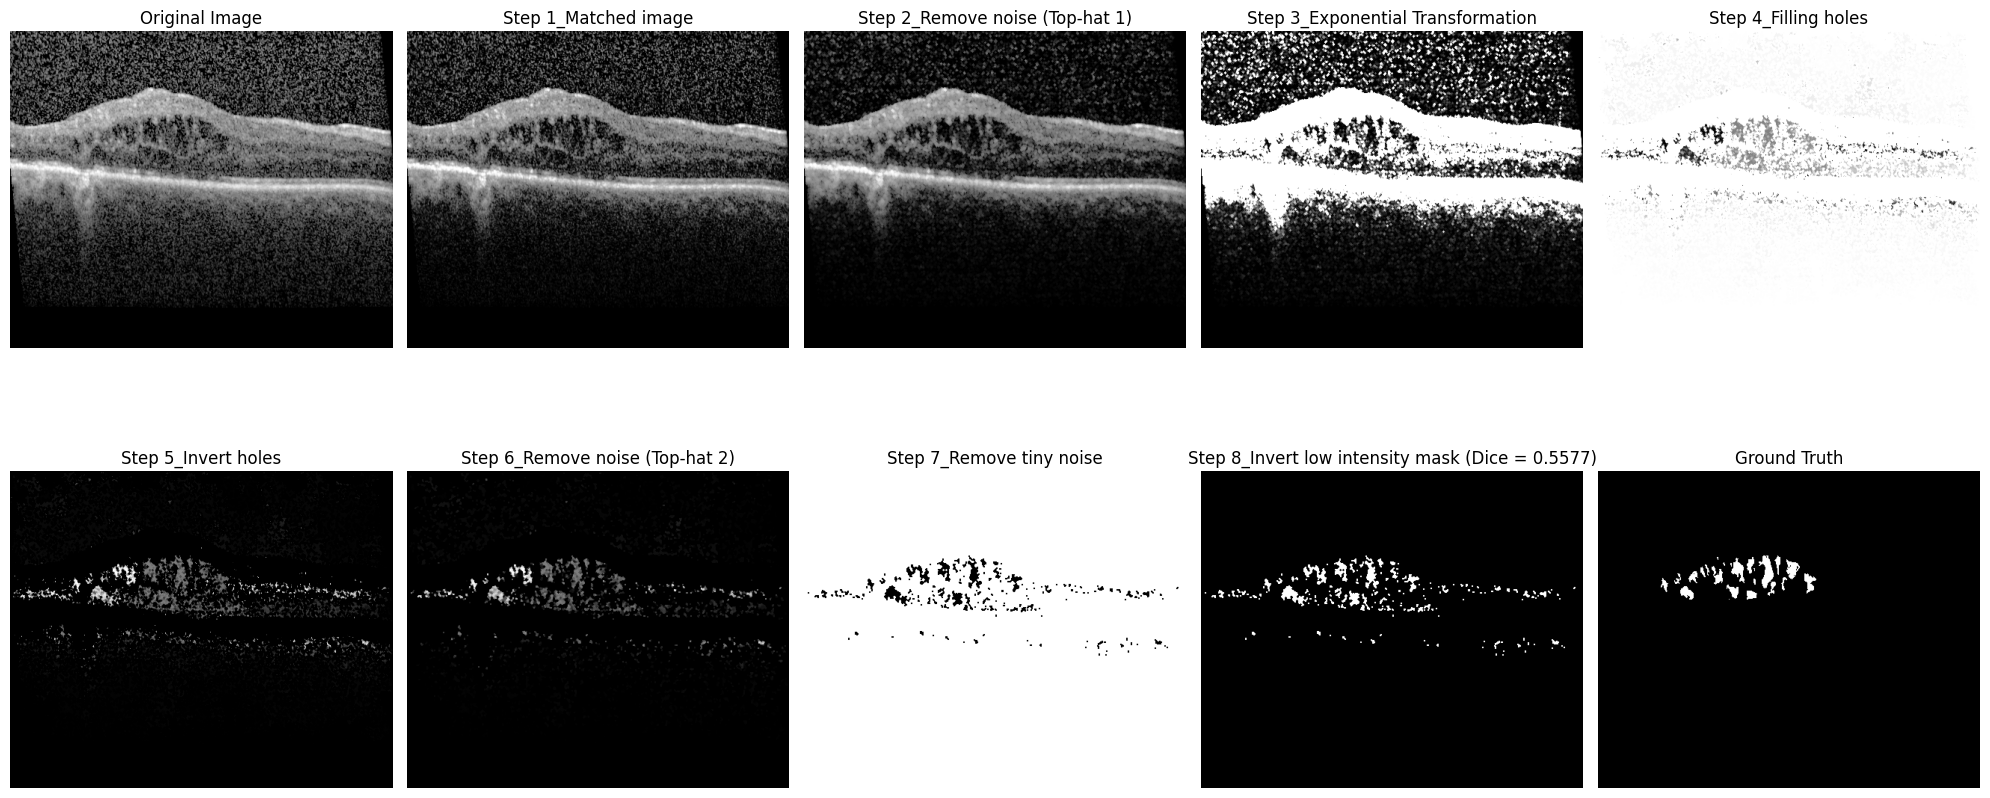

In [18]:
###Pre-processing Phase
#Step 1: Matching Histogram
reference = im6
ori_image = im4

matched = match_histograms(ori_image, reference)

#Step 2: Removing small objects in grayscale images with a top hat filter
footprint = morphology.disk(1)
res = morphology.white_tophat(matched, footprint)

removed_wobject_1 = matched - res

#Step 3: Exponential Transformation
preexp = removed_wobject_1.astype(float)
a = 0.03
c = 255 / (np.log(1 + np.abs(preexp.max())))
imexp = c * (np.power(1 + a, preexp) - 1)
imexp = np.clip(imexp, 0, 255)

###Segmentation Phase
#Step 4: Filling holes and finding peaks
prefill = imexp

seed = np.copy(imexp)
seed[1:-1, 1:-1] = prefill.max()
filled = reconstruction(seed, prefill, method='erosion') #Morphological reconstruction (filling holes)

holes = prefill - filled #only show holes

#Step 5: Invert holes
inverted_holes = invert(holes)

###Post-processing Phase
#Step 6: Removing small objects (2)
footprint2 = morphology.disk(1.5)
res2 = morphology.white_tophat(inverted_holes, footprint2)

removed_wobject_2 = inverted_holes - res2

#Step 7: Remove tiny noise with low_intensity mask
removed_lint = (removed_wobject_2 - removed_wobject_2.min()) / (removed_wobject_2.max() - removed_wobject_2.min())# normalize

thresh = filters.threshold_otsu(removed_lint) #automatic Otsu threshold

low_intensity_mask = removed_lint < (thresh + 0.07)

low_intensity_mask = morphology.remove_small_objects(low_intensity_mask, 10) #remove tiny noise

#Step 8: Invert low intensity mask
invert_lint = invert(low_intensity_mask)

#Dice
gti = gt4  #original ground truth
segmented = invert_lint

intersection = np.logical_and(gti, segmented).sum()
dice = 2 * intersection / (gti.sum() + segmented .sum()) if (gti.sum() + segmented .sum()) != 0 else 0

#Show
plt.figure(figsize=(20, 10))

# Row 1
plt.subplot(2, 5, 1)
plt.imshow(ori_image, cmap='gray')
plt.title("Original Image")
plt.axis('off')

plt.subplot(2, 5, 2)
plt.imshow(matched, cmap='gray')
plt.title("Step 1_Matched image")
plt.axis('off')

plt.subplot(2, 5, 3)
plt.imshow(removed_wobject_1, cmap='gray')
plt.title("Step 2_Remove noise (Top-hat 1)")
plt.axis('off')

plt.subplot(2, 5, 4)
plt.imshow(imexp, cmap='gray')
plt.title("Step 3_Exponential Transformation")
plt.axis('off')

plt.subplot(2, 5, 5)
plt.imshow(holes, cmap='gray')
plt.title("Step 4_Filling holes")
plt.axis('off')

# Row 2
plt.subplot(2, 5, 6)
plt.imshow(inverted_holes, cmap='gray')
plt.title("Step 5_Invert holes")
plt.axis('off')

plt.subplot(2, 5, 7)
plt.imshow(removed_wobject_2, cmap='gray')
plt.title("Step 6_Remove noise (Top-hat 2)")
plt.axis('off')

plt.subplot(2, 5, 8)
plt.imshow(low_intensity_mask, cmap='gray')
plt.title("Step 7_Remove tiny noise")
plt.axis('off')

plt.subplot(2, 5, 9)
plt.imshow(invert_lint, cmap='gray')
plt.title(f"Step 8_Invert low intensity mask (Dice = {dice:.4f})")
plt.axis('off')

plt.subplot(2, 5, 10)
plt.imshow(gti, cmap='gray')
plt.title(f"Ground Truth")
plt.axis('off')

plt.tight_layout()
plt.show()

## All images application

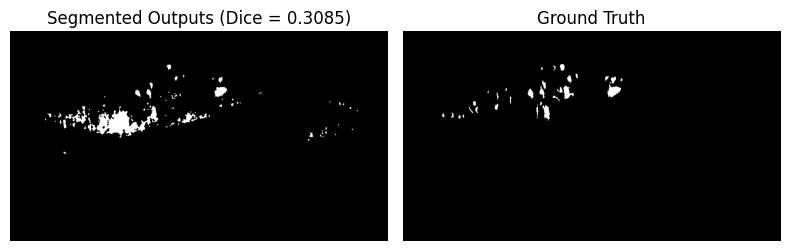

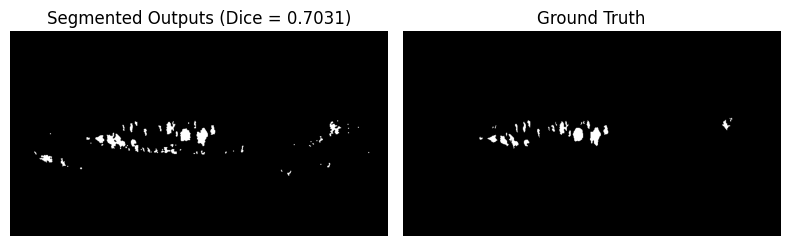

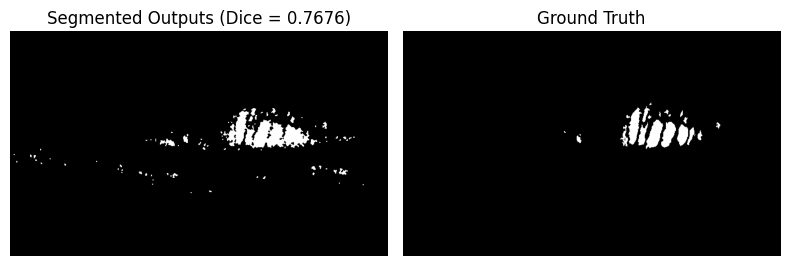

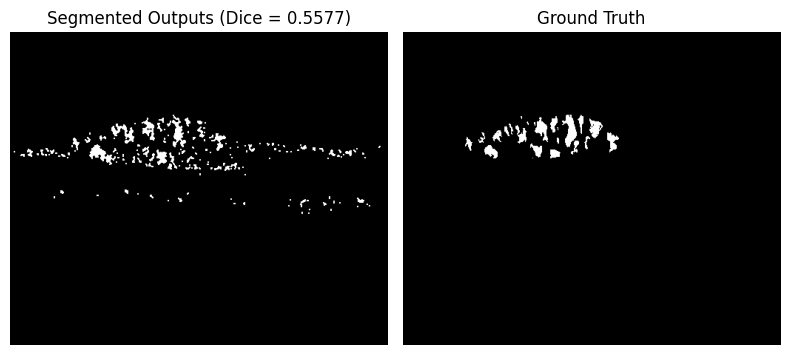

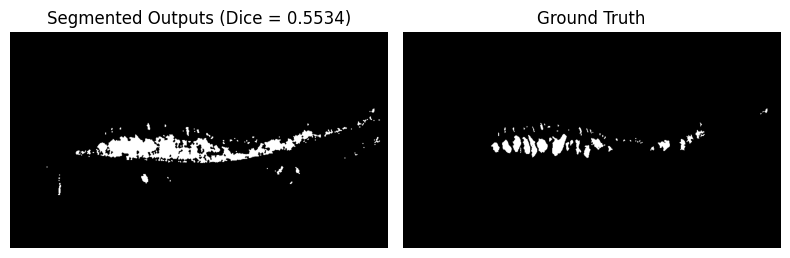

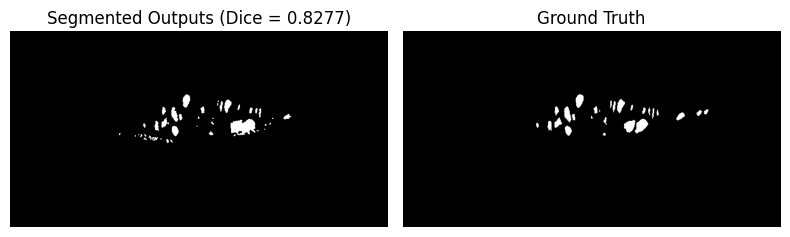

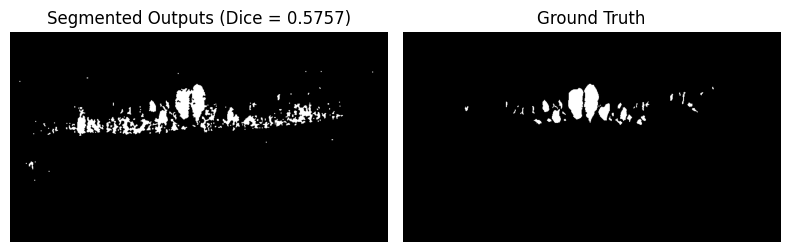

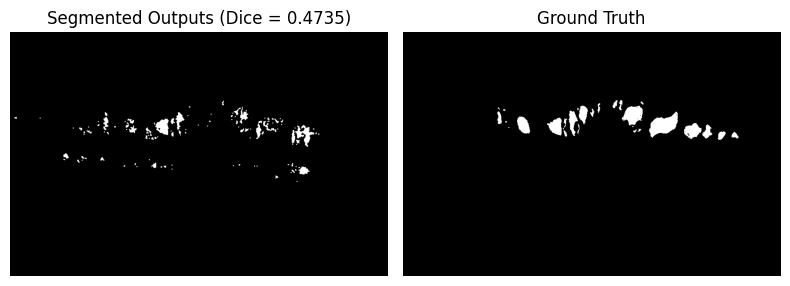

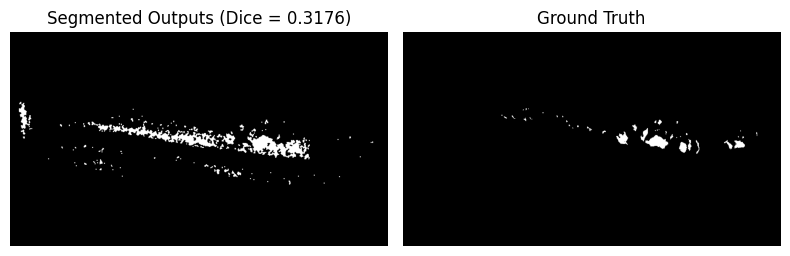

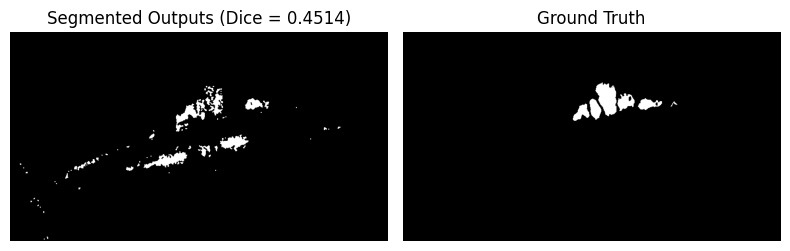

Image 1: Dice = 0.3085
Image 2: Dice = 0.7031
Image 3: Dice = 0.7676
Image 4: Dice = 0.5577
Image 5: Dice = 0.5534
Image 6: Dice = 0.8277
Image 7: Dice = 0.5757
Image 8: Dice = 0.4735
Image 9: Dice = 0.3176
Image 10: Dice = 0.4514

--Overall Segmentation Results--
Mean: 0.5536
Standard Deviation: 0.1663
Minimum Dice: 0.3085
Maximum Dice: 0.8277


In [19]:
#Apply Segmentation for all 10 Images
images = [im1, im2, im3, im4, im5, im6, im7, im8, im9, im10]
gts = [gt1, gt2, gt3, gt4, gt5, gt6, gt7, gt8, gt9, gt10]

#Matching Histogram
reference = im6

#Store final masks and Dice scores
final_masks = []
dice_scores = []

for idx, (image, gt) in enumerate(zip(images, gts), start=1):
    #Step 1: Histogram Matching
    matched = match_histograms(image, reference)

    #Step 2: Remove small objects with top-hat
    footprint1 = morphology.disk(1)
    res1 = morphology.white_tophat(matched, footprint1)
    removed_wobject_1 = matched - res1

    #Step 3: Exponential transformation
    preexp = removed_wobject_1.astype(float)
    a = 0.03
    c = 255 / (np.log(1 + np.abs(preexp.max())))
    imexp = c * (np.power(1 + a, preexp) - 1)
    imexp = np.clip(imexp, 0, 255)

    #Step 4: Fill holes
    seed = np.copy(imexp)
    seed[1:-1, 1:-1] = imexp.max()
    filled = reconstruction(seed, imexp, method='erosion')
    holes = imexp - filled

    #Step 5: Invert holes
    inverted_holes = invert(holes)

    #Step 6: Remove small objects again
    footprint2 = morphology.disk(1.5)
    res2 = morphology.white_tophat(inverted_holes, footprint2)
    removed_wobject_2 = inverted_holes - res2

    #Step 7: Low-intensity mask and remove tiny noise
    removed_lint = (removed_wobject_2 - removed_wobject_2.min()) / (removed_wobject_2.max() - removed_wobject_2.min())
    thresh = filters.threshold_otsu(removed_lint)
    low_intensity_mask = removed_lint < (thresh + 0.07)
    low_intensity_mask = morphology.remove_small_objects(low_intensity_mask, 10)

    #Step 8: Invert low-intensity mask
    invert_lint = invert(low_intensity_mask)

    #Compute Dice
    gt_bin = gt
    pred_bin = invert_lint
    intersection = np.logical_and(gt_bin, pred_bin).sum()
    dice = 2 * intersection / (gt_bin.sum() + pred_bin.sum()) if (gt_bin.sum() + pred_bin.sum()) != 0 else 0

    dice_scores.append(dice)

    #Show Step 8 result with Dice and Ground Truth
    plt.figure(figsize=(8,4))

    #Left: Segmented Outputs
    plt.subplot(1, 2, 1)
    plt.imshow(invert_lint, cmap='gray')
    plt.title(f"Segmented Outputs (Dice = {dice:.4f})")
    plt.axis('off')

    #Right: Ground truth
    plt.subplot(1, 2, 2)
    plt.imshow(gt, cmap='gray')
    plt.title("Ground Truth")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

#Summary of Dice scores
for i, d in enumerate(dice_scores, start=1):
    print(f"Image {i}: Dice = {d:.4f}")

mean_dice = np.mean(dice_scores)
std_dice = np.std(dice_scores)
min_dice = np.min(dice_scores)
max_dice = np.max(dice_scores)

#Metrics summary
print("\n--Overall Segmentation Results--")
print(f"Mean: {mean_dice:.4f}")
print(f"Standard Deviation: {std_dice:.4f}")
print(f"Minimum Dice: {min_dice:.4f}")
print(f"Maximum Dice: {max_dice:.4f}")
